In [ ]:
!pip install mediapipe

!pip install keras

!pip install --upgrade keras tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [ ]:
!unzip -O cp949 /content/MP_Data.zip -d "MP_Data(1)"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: MP_Data(1)/어지럼증/22/3.npy  
  inflating: MP_Data(1)/어지럼증/22/4.npy  
  inflating: MP_Data(1)/어지럼증/22/5.npy  
  inflating: MP_Data(1)/어지럼증/22/6.npy  
  inflating: MP_Data(1)/어지럼증/22/7.npy  
  inflating: MP_Data(1)/어지럼증/22/8.npy  
  inflating: MP_Data(1)/어지럼증/22/9.npy  
   creating: MP_Data(1)/어지럼증/23/
  inflating: MP_Data(1)/어지럼증/23/0.npy  
  inflating: MP_Data(1)/어지럼증/23/1.npy  
  inflating: MP_Data(1)/어지럼증/23/10.npy  
  inflating: MP_Data(1)/어지럼증/23/11.npy  
  inflating: MP_Data(1)/어지럼증/23/12.npy  
  inflating: MP_Data(1)/어지럼증/23/13.npy  
  inflating: MP_Data(1)/어지럼증/23/14.npy  
  inflating: MP_Data(1)/어지럼증/23/15.npy  
  inflating: MP_Data(1)/어지럼증/23/16.npy  
  inflating: MP_Data(1)/어지럼증/23/17.npy  
  inflating: MP_Data(1)/어지럼증/23/18.npy  
  inflating: MP_Data(1)/어지럼증/23/19.npy  
  inflating: MP_Data(1)/어지럼증/23/2.npy  
  inflating: MP_Data(1)/어지럼증/23/20.npy  
  inflating: MP_Data(1)/어지럼증/23/21.npy  
  inflating: MP_Data(1)/어지럼증/23/22.npy 

In [ ]:
# gpu 7 기존
import cv2
import numpy as np
import os
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard, EarlyStopping
import mediapipe as mp
import keras

# Initialize Mediapipe
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False  # Image is no longer writeable
    results = model.process(image)  # Make prediction
    image.flags.writeable = True  # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR CONVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )
    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/content/MP_Data(1)')

# Actions that we try to detect
actions = np.array(['감기','다치다','두통','몸살','배탈','병','약','열'])

# Videos are going to be 30 frames in length
sequence_length = 30

label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            npy_path = os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num))
            print(f"Attempting to load: {npy_path}")
            if os.path.isfile(npy_path):
                res = np.load(npy_path)
                window.append(res)
                print(f"Loaded frame {frame_num} for sequence {sequence} of action '{action}'")
            else:
                print(f"File {npy_path} does not exist, adding zeros!")
                window.append(np.zeros(1662))  # Add zero array to maintain the sequence length
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.2 = 0.05

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Callbacks
tensorboard_cb = keras.callbacks.ModelCheckpoint('best-model8.keras',save_best_only=True)
early_stopping_cb = EarlyStopping(patience=30, restore_best_weights=True)

# Fit model with TensorBoard and EarlyStopping callbacks
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val))

# Save model
model.save('best-model8.keras')

# Load the model for prediction
model = tf.keras.models.load_model('best-model8.keras')

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on real-time input
sequence = []
sentence = []
threshold = 0.7

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            # 3. Viz logic
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Display the prediction on the image
            cv2.putText(image, ' '.join(sentence), (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Attempting to load: /content/MP_Data(1)/감기/42/20.npy
Loaded frame 20 for sequence 42 of action '감기'
Attempting to load: /content/MP_Data(1)/감기/42/21.npy
Loaded frame 21 for sequence 42 of action '감기'
Attempting to load: /content/MP_Data(1)/감기/42/22.npy
Loaded frame 22 for sequence 42 of action '감기'
Attempting to load: /content/MP_Data(1)/감기/42/23.npy
Loaded frame 23 for sequence 42 of action '감기'
Attempting to load: /content/MP_Data(1)/감기/42/24.npy
Loaded frame 24 for sequence 42 of action '감기'
Attempting to load: /content/MP_Data(1)/감기/42/25.npy
Loaded frame 25 for sequence 42 of action '감기'
Attempting to load: /content/MP_Data(1)/감기/42/26.npy
Loaded frame 26 for sequence 42 of action '감기'
Attempting to load: /content/MP_Data(1)/감기/42/27.npy
Loaded frame 27 for sequence 42 of action '감기'
Attempting to load: /content/MP_Data(1)/감기/42/28.npy
Loaded frame 28 for sequence 42 of action '감기'
Attempting to load: /content/MP_Data(1)/감기/42/29.npy
Loaded fram

KeyboardInterrupt: 

In [ ]:
# gpu 12 기존
import cv2
import numpy as np
import os
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard, EarlyStopping
import mediapipe as mp
import keras

# Initialize Mediapipe
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False  # Image is no longer writeable
    results = model.process(image)  # Make prediction
    image.flags.writeable = True  # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR CONVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )
    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/content/MP_Data(1)')

# Actions that we try to detect
actions = np.array(['감기', '낫다','다치다','두통','몸살','배탈','병','약','어지럼증','열','이다','a'])

# Videos are going to be 30 frames in length
sequence_length = 30

label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            npy_path = os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num))
            print(f"Attempting to load: {npy_path}")
            if os.path.isfile(npy_path):
                res = np.load(npy_path)
                window.append(res)
                print(f"Loaded frame {frame_num} for sequence {sequence} of action '{action}'")
            else:
                print(f"File {npy_path} does not exist, adding zeros!")
                window.append(np.zeros(1662))  # Add zero array to maintain the sequence length
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.2 = 0.05

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Callbacks
tensorboard_cb = keras.callbacks.ModelCheckpoint('best-model12.keras',save_best_only=True)
early_stopping_cb = EarlyStopping(patience=30, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val))

# Save model
model.save('best-model12.keras')

# Load the model for prediction
model = tf.keras.models.load_model('best-model12.keras')

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plotting the loss and accuracy
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Attempting to load: /content/MP_Data(1)/이다/49/20.npy
Loaded frame 20 for sequence 49 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/49/21.npy
Loaded frame 21 for sequence 49 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/49/22.npy
Loaded frame 22 for sequence 49 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/49/23.npy
Loaded frame 23 for sequence 49 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/49/24.npy
Loaded frame 24 for sequence 49 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/49/25.npy
Loaded frame 25 for sequence 49 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/49/26.npy
Loaded frame 26 for sequence 49 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/49/27.npy
Loaded frame 27 for sequence 49 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/49/28.npy
Loaded frame 28 for sequence 49 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/49/29.npy
Loaded fram

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - categorical_accuracy: 0.1033 - loss: 2.4883 - val_categorical_accuracy: 0.0755 - val_loss: 2.4816
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - categorical_accuracy: 0.1050 - loss: 2.4695 - val_categorical_accuracy: 0.0755 - val_loss: 2.4802
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - categorical_accuracy: 0.1250 - loss: 2.4357 - val_categorical_accuracy: 0.1226 - val_loss: 2.4061
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - categorical_accuracy: 0.1596 - loss: 2.3441 - val_categorical_accuracy: 0.1226 - val_loss: 2.3293
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - categorical_accuracy: 0.1732 - loss: 2.2945 - val_categorical_accuracy: 0.1132 - val_loss: 2.2473
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - categorical_accuracy: 0.1567 - loss: 2.2410 - val_categorical_accuracy: 0.1509 - val_loss: 2.2120
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - categorical_accuracy: 0.212

KeyError: 'accuracy'

2/2 - 3s - 1s/step - categorical_accuracy: 0.8333 - loss: 1.7514
Test Loss: 1.7513902187347412
Test Accuracy: 0.8333333134651184


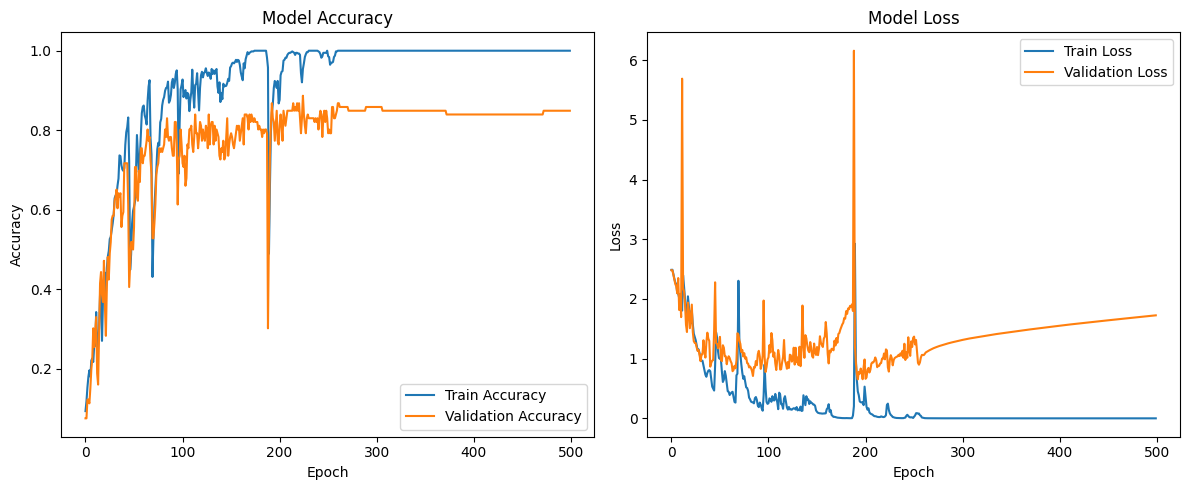

In [ ]:
import matplotlib.pyplot as plt
# Load the model for prediction
model = tf.keras.models.load_model('best-model12.keras')

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plotting the loss and accuracy
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()



In [ ]:
# gpu 12 콜백
import cv2
import numpy as np
import os
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard, EarlyStopping
import mediapipe as mp
import keras

# Initialize Mediapipe
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False  # Image is no longer writeable
    results = model.process(image)  # Make prediction
    image.flags.writeable = True  # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR CONVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )
    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/content/MP_Data(1)')

# Actions that we try to detect
actions = np.array(['감기', '낫다','다치다','독감','몸살','배탈','병','약','어지럼증','열','이다','a'])

# Videos are going to be 30 frames in length
sequence_length = 30

label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            npy_path = os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num))
            print(f"Attempting to load: {npy_path}")
            if os.path.isfile(npy_path):
                res = np.load(npy_path)
                window.append(res)
                print(f"Loaded frame {frame_num} for sequence {sequence} of action '{action}'")
            else:
                print(f"File {npy_path} does not exist, adding zeros!")
                window.append(np.zeros(1662))  # Add zero array to maintain the sequence length
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.2 = 0.05

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Callbacks
tensorboard_cb = keras.callbacks.ModelCheckpoint('best-model12.keras',save_best_only=True)
early_stopping_cb = EarlyStopping(patience=30, restore_best_weights=True)

# Fit model with TensorBoard and EarlyStopping callbacks
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), callbacks=[tensorboard_cb])


# Load the model for prediction
model = tf.keras.models.load_model('best-model12.keras')

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on real-time input
sequence = []
sentence = []
threshold = 0.7

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            # 3. Viz logic
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Display the prediction on the image
            cv2.putText(image, ' '.join(sentence), (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


Streaming output truncated to the last 5000 lines.
Loaded frame 11 for sequence 37 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/37/12.npy
Loaded frame 12 for sequence 37 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/37/13.npy
Loaded frame 13 for sequence 37 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/37/14.npy
Loaded frame 14 for sequence 37 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/37/15.npy
Loaded frame 15 for sequence 37 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/37/16.npy
Loaded frame 16 for sequence 37 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/37/17.npy
Loaded frame 17 for sequence 37 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/37/18.npy
Loaded frame 18 for sequence 37 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/37/19.npy
Loaded frame 19 for sequence 37 of action '이다'
Attempting to load: /content/MP_Data(1)/이다/37/20.npy
Loaded frame 20 for sequence 37 of action '이다'
At

In [ ]:
# gpu 7 콜백
import cv2
import numpy as np
import os
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard, EarlyStopping
import mediapipe as mp
import keras

# Initialize Mediapipe
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False  # Image is no longer writeable
    results = model.process(image)  # Make prediction
    image.flags.writeable = True  # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR CONVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )
    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/content/MP_Data(1)')

# Actions that we try to detect
actions = np.array(['감기','다치다','두통','몸살','배탈','병','약','열'])

# Videos are going to be 30 frames in length
sequence_length = 30

label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            npy_path = os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num))
            print(f"Attempting to load: {npy_path}")
            if os.path.isfile(npy_path):
                res = np.load(npy_path)
                window.append(res)
                print(f"Loaded frame {frame_num} for sequence {sequence} of action '{action}'")
            else:
                print(f"File {npy_path} does not exist, adding zeros!")
                window.append(np.zeros(1662))  # Add zero array to maintain the sequence length
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.2 = 0.05

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Callbacks
tensorboard_cb = keras.callbacks.ModelCheckpoint('best-model8.keras',save_best_only=True)
early_stopping_cb = EarlyStopping(patience=30, restore_best_weights=True)

# Fit model with TensorBoard and EarlyStopping callbacks
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), callbacks=[tensorboard_cb])

# Save model
model.save('best-model8.keras')

# Load the model for prediction
model = tf.keras.models.load_model('best-model8.keras')

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on real-time input
sequence = []
sentence = []
threshold = 0.7

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            # 3. Viz logic
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Display the prediction on the image
            cv2.putText(image, ' '.join(sentence), (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Loaded frame 11 for sequence 46 of action '약'
Attempting to load: /content/MP_Data(1)/약/46/12.npy
Loaded frame 12 for sequence 46 of action '약'
Attempting to load: /content/MP_Data(1)/약/46/13.npy
Loaded frame 13 for sequence 46 of action '약'
Attempting to load: /content/MP_Data(1)/약/46/14.npy
Loaded frame 14 for sequence 46 of action '약'
Attempting to load: /content/MP_Data(1)/약/46/15.npy
Loaded frame 15 for sequence 46 of action '약'
Attempting to load: /content/MP_Data(1)/약/46/16.npy
Loaded frame 16 for sequence 46 of action '약'
Attempting to load: /content/MP_Data(1)/약/46/17.npy
Loaded frame 17 for sequence 46 of action '약'
Attempting to load: /content/MP_Data(1)/약/46/18.npy
Loaded frame 18 for sequence 46 of action '약'
Attempting to load: /content/MP_Data(1)/약/46/19.npy
Loaded frame 19 for sequence 46 of action '약'
Attempting to load: /content/MP_Data(1)/약/46/20.npy
Loaded frame 20 for sequence 46 of action '약'
Attempting to load: /content/MP_Data

In [ ]:
# gpu 12 얼리스탑
import cv2
import numpy as np
import os
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard, EarlyStopping
import mediapipe as mp
import keras

# Initialize Mediapipe
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False  # Image is no longer writeable
    results = model.process(image)  # Make prediction
    image.flags.writeable = True  # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR CONVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )
    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/content/MP_Data(1)')

# Actions that we try to detect
actions = np.array(['감기', '낫다','다치다','독감','두통','몸살','배탈','병','약','어지럼증','열','이다'])

# Videos are going to be 30 frames in length
sequence_length = 30

label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            npy_path = os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num))
            print(f"Attempting to load: {npy_path}")
            if os.path.isfile(npy_path):
                res = np.load(npy_path)
                window.append(res)
                print(f"Loaded frame {frame_num} for sequence {sequence} of action '{action}'")
            else:
                print(f"File {npy_path} does not exist, adding zeros!")
                window.append(np.zeros(1662))  # Add zero array to maintain the sequence length
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.2 = 0.05

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Callbacks
tensorboard_cb = keras.callbacks.ModelCheckpoint('best-model12.keras',save_best_only=True)
early_stopping_cb = EarlyStopping(patience=30, restore_best_weights=True)

# Fit model with TensorBoard and EarlyStopping callbacks
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), callbacks=[tensorboard_cb, early_stopping_cb])

# Load the model for prediction
model = tf.keras.models.load_model('best-model12.keras')

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on real-time input
sequence = []
sentence = []
threshold = 0.7

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            # 3. Viz logic
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Display the prediction on the image
            cv2.putText(image, ' '.join(sentence), (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Attempting to load: /content/MP_Data(1)/열/39/20.npy
Loaded frame 20 for sequence 39 of action '열'
Attempting to load: /content/MP_Data(1)/열/39/21.npy
Loaded frame 21 for sequence 39 of action '열'
Attempting to load: /content/MP_Data(1)/열/39/22.npy
Loaded frame 22 for sequence 39 of action '열'
Attempting to load: /content/MP_Data(1)/열/39/23.npy
Loaded frame 23 for sequence 39 of action '열'
Attempting to load: /content/MP_Data(1)/열/39/24.npy
Loaded frame 24 for sequence 39 of action '열'
Attempting to load: /content/MP_Data(1)/열/39/25.npy
Loaded frame 25 for sequence 39 of action '열'
Attempting to load: /content/MP_Data(1)/열/39/26.npy
Loaded frame 26 for sequence 39 of action '열'
Attempting to load: /content/MP_Data(1)/열/39/27.npy
Loaded frame 27 for sequence 39 of action '열'
Attempting to load: /content/MP_Data(1)/열/39/28.npy
Loaded frame 28 for sequence 39 of action '열'
Attempting to load: /content/MP_Data(1)/열/39/29.npy
Loaded frame 29 for sequence 3

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - categorical_accuracy: 0.1074 - loss: 5.7119 - val_categorical_accuracy: 0.0566 - val_loss: 2.5069
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - categorical_accuracy: 0.0893 - loss: 2.5527 - val_categorical_accuracy: 0.1792 - val_loss: 2.3804
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - categorical_accuracy: 0.1357 - loss: 2.3895 - val_categorical_accuracy: 0.0849 - val_loss: 2.3370
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - categorical_accuracy: 0.1099 - loss: 2.3477 - val_categorical_accuracy: 0.1981 - val_loss: 2.1637
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - categorical_accuracy: 0.1938 - loss: 2.1233 - val_categorical_accuracy: 0.2547 - val_loss: 2.1702
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - categorical_accuracy: 0.2018 - loss: 2.1244 - val_categorical_accuracy: 0.2264 - val_loss: 2.0187
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - categorical_accuracy: 0.239

KeyboardInterrupt: 

In [ ]:
#gpu 7 얼리스탑
import cv2
import numpy as np
import os
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard, EarlyStopping
import mediapipe as mp
import keras

# Initialize Mediapipe
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False  # Image is no longer writeable
    results = model.process(image)  # Make prediction
    image.flags.writeable = True  # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR CONVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )
    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/content/MP_Data(1)')

# Actions that we try to detect
actions = np.array(['감기','다치다','두통','몸살','배탈','병','약','열'])

# Videos are going to be 30 frames in length
sequence_length = 30

label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            npy_path = os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num))
            print(f"Attempting to load: {npy_path}")
            if os.path.isfile(npy_path):
                res = np.load(npy_path)
                window.append(res)
                print(f"Loaded frame {frame_num} for sequence {sequence} of action '{action}'")
            else:
                print(f"File {npy_path} does not exist, adding zeros!")
                window.append(np.zeros(1662))  # Add zero array to maintain the sequence length
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.2 = 0.05

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Callbacks
tensorboard_cb = keras.callbacks.ModelCheckpoint('best-model8.keras',save_best_only=True)
early_stopping_cb = EarlyStopping(patience=30, restore_best_weights=True)

# Fit model with TensorBoard and EarlyStopping callbacks
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), callbacks=[tensorboard_cb, early_stopping_cb])

# Save model
model.save('best-model8.keras')

# Load the model for prediction
model = tf.keras.models.load_model('best-model8.keras')

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on real-time input
sequence = []
sentence = []
threshold = 0.7

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            # 3. Viz logic
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Display the prediction on the image
            cv2.putText(image, ' '.join(sentence), (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Loaded frame 3 for sequence 38 of action '약'
Attempting to load: /content/MP_Data(1)/약/38/4.npy
Loaded frame 4 for sequence 38 of action '약'
Attempting to load: /content/MP_Data(1)/약/38/5.npy
Loaded frame 5 for sequence 38 of action '약'
Attempting to load: /content/MP_Data(1)/약/38/6.npy
Loaded frame 6 for sequence 38 of action '약'
Attempting to load: /content/MP_Data(1)/약/38/7.npy
Loaded frame 7 for sequence 38 of action '약'
Attempting to load: /content/MP_Data(1)/약/38/8.npy
Loaded frame 8 for sequence 38 of action '약'
Attempting to load: /content/MP_Data(1)/약/38/9.npy
Loaded frame 9 for sequence 38 of action '약'
Attempting to load: /content/MP_Data(1)/약/38/10.npy
Loaded frame 10 for sequence 38 of action '약'
Attempting to load: /content/MP_Data(1)/약/38/11.npy
Loaded frame 11 for sequence 38 of action '약'
Attempting to load: /content/MP_Data(1)/약/38/12.npy
Loaded frame 12 for sequence 38 of action '약'
Attempting to load: /content/MP_Data(1)/약/38/13.n

In [ ]:
#데이터 생성
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
import tensorflow as tf
from keras.models import load_model

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False # Image is no longer writeable
    results = model.process(image) # Make prediction
    image.flags.writeable = True # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )
    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')

# Actions that we try to detect
actions = np.array(['감기', '낫다','다치다','독감','두통','몸살','배탈','병','약','어지럼증','열','이다'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Ensure the main directory exists
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Create folders for each action if they don't exist
for action in actions:
    action_dir = os.path.join(DATA_PATH, action)
    if not os.path.exists(action_dir):
        os.makedirs(action_dir)
    dirmax = np.max(np.array(os.listdir(action_dir)).astype(int)) if os.path.exists(action_dir) and len(os.listdir(action_dir)) > 0 else 0
    for sequence in range(1, no_sequences + 1):
        try:
            os.makedirs(os.path.join(action_dir, str(dirmax + sequence)))
        except Exception as e:
            print(f"Error creating directory: {e}")

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(dirmax, dirmax + no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # NEW Apply wait logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                # Ensure the directory exists before saving the file
                npy_path_dir = os.path.join(DATA_PATH, action, str(sequence))
                if not os.path.exists(npy_path_dir):
                    os.makedirs(npy_path_dir)

                # Debugging statements
                print(f"Attempting to save to path: {npy_path_dir}")

                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(npy_path_dir, str(frame_num) + '.npy')
                try:
                    np.save(npy_path, keypoints)
                    # Debug message
                    print(f"Saved frame {frame_num} for sequence {sequence} of action '{action}' to {npy_path}")
                except Exception as e:
                    print(f"Error saving file {npy_path}: {e}")

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            npy_path = os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num))
            print(f"Attempting to load: {npy_path}")
            if os.path.isfile(npy_path):
                res = np.load(npy_path)
                window.append(res)
                print(f"Loaded frame {frame_num} for sequence {sequence} of action '{action}'")
            else:
                print(f"File {npy_path} does not exist, adding zeros!")
                window.append(np.zeros(1662)) # Add zero array to maintain the sequence length
        sequences.append(window)
        labels.append(label_map[action])



In [ ]:
#예측 -> 미디어로
import cv2
import numpy as np
import os
import mediapipe as mp
from keras.models import load_model
from openai import OpenAI
from gtts import gTTS
from PIL import ImageFont, ImageDraw, Image
import requests
#import playsound


# 미디어파이프와 관련된 설정
mp_holistic = mp.solutions.holistic  # 홀리스틱 모델
mp_drawing = mp.solutions.drawing_utils  # 랜드마크 그리기 유틸리티

# 한글 폰트 파일 다운로드
def download_font(font_url):
    response = requests.get(font_url)
    if response.status_code == 200:
        font_path = "NanumGothic-Regular.ttf"
        with open(font_path, "wb") as f:
            f.write(response.content)
        return font_path
    else:
        raise Exception("Failed to download the font")

# 한글 텍스트 표시 함수 (Pillow 사용)
def put_korean_text(image, text, position, font_size, color, font_path):
    # OpenCV 이미지를 Pillow로 변환
    image_pil = Image.fromarray(image)
    draw = ImageDraw.Draw(image_pil)

    # 한글 폰트 로드
    font = ImageFont.truetype(font_path, font_size)

    # 텍스트 추가
    draw.text(position, text, font=font, fill=color)

    # Pillow 이미지를 다시 OpenCV 이미지로 변환
    return np.array(image_pil)

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

# 모델 불러오기
model_path = os.path.join(os.getcwd(), 'best-model12.h5')
model = load_model(model_path)

# 예측을 위한 변수 초기화
sequence = []
sentence = []
predictions = []
threshold = 0.5

# 사용할 액션 정의 (이전에 정의한 액션과 일치해야 함)
#actions = np.array(['감기', '다치다', '두통', '몸살', '배탈', '병', '약', '열'])
actions = np.array(['감기', '낫다','다치다','독감','두통','몸살','배탈','병','약','어지럼증','열','이다'])


# 색상 설정
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)] * (len(actions) // 3 + 1)
colors = colors[:len(actions)]

# Google Fonts에서 폰트 다운로드
font_url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"
font_path = download_font(font_url)

# 웹캠 피드 열기
cap = cv2.VideoCapture(0)

# Mediapipe 모델 설정
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        # 예측 수행
        image, results = mediapipe_detection(frame, holistic)

        # 키포인트 추출 및 시퀀스 업데이트
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))

            # 예측 시각화 및 문장 생성
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)

        # 한글 텍스트 표시
        korean_sentence = ' '.join(sentence)
        image = put_korean_text(image, korean_sentence, (3, 30), 30, (255, 255, 255), font_path)

        cv2.imshow('OpenCV Feed', image)

        # 'q' 키를 눌러 종료
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Convert the list into a string, joining with spaces or another separator
list_as_string = " ".join(map(str,sentence))
print(sentence)

client = OpenAI(api_key="sk-proj-89VeNxZj9PnGK1pd2Y1TT3BlbkFJuBxmprFaTJEWX7Ubdph3")

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": f"너는 환자야. 다음 주어진 단어를 사용해서 환자가 병원에서 의사한테 말 할 자연스러운 문장으로 만들어줘: {list_as_string}"}
    ]
)

# Print the assistant's response
print(response.choices[0].message.content)

def speak(text):
    tts = gTTS(text=text, lang='ko')
    filename = 'voice.mp3'
    tts.save(filename)
    #playsound.playsound(filename)
    #os.remove(filename)

# GPT의 응답을 음성으로 출력
speak(response.choices[0].message.content)


In [ ]:
!pip install transformers

In [ ]:
pipe = pipeline('text-generation', model='kogpt') #kogpt로 모델 입력


NameError: name 'pipeline' is not defined

In [ ]:
from transformers import pipeline

pipe = pipeline("text-generation", model="gpt2", max_length=30)
pipe("감기, 독감, 열, 배탈")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': '감기, 독감, 열, 배탈서습'}]